# Black-Scholes Pricing Model


**Variables:**
* $C$: Call Option Value
* $S$: Current stock price
* $K$: Strike price
* $T$: Time to expiration (in years)
* $r$: Risk-free interest rate (annualized)
* $q$: Dividend yield (annualized)
* $\sigma$: Volatility of the stock's returns (annualized standard deviation)
* $N()$: Cumulative standard normal distribution function


## Call Option Value:

$$C = Se^{-qT} N(d_1) - Ke^{-rT} N(d_2)$$

where:

$$d_1 = \frac{\ln(S/K) + (r - q + 0.5\sigma^2)T}{\sigma\sqrt{T}}$$

$$d_2 = d_1 - \sigma\sqrt{T}$$

## Cumulative Standard Normal Distribution $N(d_1)$ and $N(d_2)$:

$N(d_1)$ and $N(d_2)$ represent the cumulative distribution function (CDF) of the standard normal distribution evaluated at $d_1$ and $d_2$ respectively:

$$N(d_1) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{d_1} e^{-\frac{x^2}{2}} dx$$

$$N(d_2) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{d_2} e^{-\frac{x^2}{2}} dx$$

This gives the probability that a standard normal random variable is less than or equal to $d_1$ (or $d_2$). In the Black-Scholes context:
* $N(d_1)$ represents the probability of the option being exercised under the risk-neutral measure, adjusted for the stock price dynamics
* $N(d_2)$ represents the probability of the option expiring in-the-money

## Brownian Motion in Black-Scholes:

The Black-Scholes model assumes that the underlying stock price follows a **geometric Brownian motion** (GBM), which is described by the stochastic differential equation:

$$dS_t = \mu S_t dt + \sigma S_t dW_t$$

where:
* $S_t$: Stock price at time $t$
* $\mu$: Expected return (drift) of the stock
* $\sigma$: Volatility of the stock
* $dW_t$: Increment of a **Wiener process** (standard Brownian motion)

### Standard Brownian Motion (Wiener Process) $W_t$:

A standard Brownian motion $W_t$ is a continuous-time stochastic process with the following properties:

1. **Initial condition**: $W_0 = 0$
2. **Independent increments**: For $0 \leq s < t$, $W_t - W_s$ is independent of $W_s$
3. **Normal increments**: $W_t - W_s \sim \mathcal{N}(0, t-s)$
4. **Continuous paths**: $W_t$ has continuous sample paths (almost surely)

The increment $dW_t$ in the GBM equation represents an infinitesimal random change that is normally distributed with:
* Mean: $0$
* Variance: $dt$

This Brownian motion assumption allows the Black-Scholes formula to be derived using Itô's lemma and the risk-neutral pricing framework.


In [1]:
# Import required libraries
# JAX is used for automatic differentiation (gradient calculation) needed for IV solving
from jax.scipy.stats import norm as jnorm
import jax.numpy as jnp
from jax import grad
import numpy as np

# Data manipulation and date handling
import pandas as pd
from datetime import datetime

# Visualization libraries - Matplotlib for 3D plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import griddata

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## Project Overview: Crypto Options Volatility Surface Analysis

This notebook analyzes **implied volatility surfaces** for Bitcoin (BTC) and Ethereum (ETH) options. 

### What is an Implied Volatility Surface?

An **implied volatility surface** is a 3D representation showing how implied volatility varies across:
- **Moneyness (S/K)**: The ratio of current underlying price to strike price
  - S/K = 1.0 means the option is at-the-money
  - S/K > 1.0 means the option is in-the-money (for calls)
  - S/K < 1.0 means the option is out-of-the-money (for calls)
- **Time to Expiration (T)**: How long until the option expires (in years)

### Why is this important?

The volatility surface reveals:
1. **Volatility Smile/Skew**: How IV changes with moneyness (often higher for out-of-the-money options)
2. **Term Structure**: How IV changes with time to expiration
3. **Market Sentiment**: Higher IV indicates higher expected price volatility
4. **Trading Opportunities**: Identify mispriced options or arbitrage opportunities

### Data Source

We'll be using real options data for BTC and ETH from CSV files containing:
- Strike prices
- Expiration dates
- Market prices (mark prices)
- Underlying asset prices


## Step 1: Black-Scholes Pricing Function

We'll implement the Black-Scholes formula to calculate theoretical option prices. This is essential because we'll use it to **reverse-engineer** the implied volatility from market prices.

**How it works**: Given all parameters (S, K, T, r, σ, q), the Black-Scholes formula calculates the theoretical option price. We'll use this in reverse: given the market price, we'll find the σ (volatility) that makes the theoretical price match the market price.


In [2]:
def black_scholes(S, K, T, r, sigma, q=0, otype="call"):
    """
    Calculate Black-Scholes option price using the formula from the theory section.
    
    Parameters:
    -----------
    S : float
        Current underlying asset price
    K : float
        Strike price
    T : float
        Time to expiration (in years)
    r : float
        Risk-free interest rate (annualized)
    sigma : float
        Volatility (annualized standard deviation)
    q : float, default=0
        Dividend yield (0 for crypto assets)
    otype : str, default="call"
        Option type: "call" or "put"
    
    Returns:
    --------
    float
        Theoretical option price
    """
    # Calculate d1 and d2 as per the Black-Scholes formula
    d1 = (jnp.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * jnp.sqrt(T))
    d2 = d1 - sigma * jnp.sqrt(T)

    if otype == "call":
        # Call option: C = Se^(-qT) * N(d1) - Ke^(-rT) * N(d2)
        call = S * jnp.exp(-q * T) * jnorm.cdf(d1, 0, 1) - K * jnp.exp(-r * T) * jnorm.cdf(d2, 0, 1)
        return call
    else:
        # Put option: P = Ke^(-rT) * N(-d2) - Se^(-qT) * N(-d1)
        put = K * jnp.exp(-r * T) * jnorm.cdf(-d2, 0, 1) - S * jnp.exp(-q * T) * jnorm.cdf(-d1, 0, 1)
        return put

print("✓ Black-Scholes pricing function defined")


✓ Black-Scholes pricing function defined


## Step 2: Implied Volatility Solver (Available but Not Used)

**What is Implied Volatility?**

Implied volatility (IV) is the volatility parameter that, when plugged into the Black-Scholes formula, produces a theoretical price equal to the market price. It represents the market's expectation of future volatility.

**Note**: For this analysis, we'll use the **implied volatility provided by Deribit** (in the `mark_iv` column) rather than calculating it ourselves. However, the IV solver functions below are still implemented and available if you want to calculate your own IV from market prices.

**How we could solve for it (if needed):**

We use **Newton's method** (also called Newton-Raphson) to find the root of the equation:
- Loss = Theoretical Price(σ) - Market Price = 0

We need the gradient (derivative) of the loss function with respect to σ. This is where **JAX** comes in handy - it automatically computes gradients for us!

**Algorithm:**
1. Start with an initial guess for σ (e.g., 0.5 = 50%)
2. Calculate the loss (difference between theoretical and market price)
3. Calculate the gradient (how sensitive the price is to changes in σ)
4. Update: σ_new = σ_old - loss / gradient
5. Repeat until convergence (loss is close to zero)


In [3]:
# Define the loss function: difference between theoretical and market price
def loss_func(S, K, T, r, sigma_guess, price, q=0, otype="call"):
    """
    Loss function for IV solving.
    Returns the difference between theoretical BS price and market price.
    We want this to be zero.
    """
    theoretical_price = black_scholes(S, K, T, r, sigma_guess, q, otype=otype)
    return theoretical_price - price

# Use JAX's automatic differentiation to compute the gradient
# This gives us the derivative of loss with respect to sigma (the 4th argument, index 4)
loss_grad_func = grad(loss_func, argnums=4)

def solve_for_iv(S, K, T, r, price, sigma_guess=0.5, q=0, otype="call",
                 N_iter=20, epsilon=0.001, verbose=False):
    """
    Solve for implied volatility using Newton's method.
    
    Parameters:
    -----------
    S, K, T, r, price, q, otype : Black-Scholes parameters
    sigma_guess : float, default=0.5
        Initial guess for volatility (50% annualized)
    N_iter : int, default=20
        Maximum number of iterations
    epsilon : float, default=0.001
        Convergence threshold (stop when |loss| < epsilon)
    
    Returns:
    --------
    float
        Implied volatility (as a decimal, e.g., 0.5 = 50%)
    """
    converged = False
    sigma = sigma_guess

    for i in range(N_iter):
        # Calculate current loss
        loss_val = float(loss_func(S, K, T, r, sigma, price, q, otype=otype))
        
        # Check if we've converged (theoretical price matches market price)
        if abs(loss_val) < epsilon:
            converged = True
            break
        else:
            # Calculate gradient (derivative of loss with respect to sigma)
            loss_grad_val = float(loss_grad_func(S, K, T, r, sigma, price, q, otype=otype))
            
            # Avoid division by zero
            if abs(loss_grad_val) < 1e-10:
                break
                
            # Newton's method update: sigma_new = sigma_old - loss / gradient
            sigma = sigma - loss_val / loss_grad_val
            
            # Ensure sigma stays positive (volatility can't be negative)
            sigma = max(0.001, sigma)

    if not converged and verbose:
        print(f"Did not converge for K={K}, T={T:.2f}")

    return sigma

def calculate_time_to_expiry(expiry_date_str, current_date=None):
    """
    Calculate time to expiration in years from expiry date string.
    
    Parameters:
    -----------
    expiry_date_str : str
        Expiry date as string (e.g., "2025-12-10")
    current_date : datetime, optional
        Current date (defaults to now)
    
    Returns:
    --------
    float or None
        Time to expiration in years, or None if already expired
    """
    if current_date is None:
        current_date = datetime.now()
    else:
        current_date = pd.to_datetime(current_date)
    
    expiry_date = pd.to_datetime(expiry_date_str)
    days_to_expiry = (expiry_date - current_date).days
    
    if days_to_expiry <= 0:
        return None  # Option already expired
    
    return days_to_expiry / 365.25  # Convert days to years

print("✓ Implied volatility solver functions defined")


✓ Implied volatility solver functions defined


## Step 3: Load Options Data

We'll load real options data for Bitcoin and Ethereum from CSV files. Each file contains:
- **Strike prices**: Different exercise prices available
- **Expiration dates**: When each option expires
- **Market prices**: Current mark prices (mid-market prices)
- **Underlying prices**: Current BTC/ETH spot prices
- **Option types**: Call (C) or Put (P)

**Note**: We'll focus on **call options** for this analysis, but the same methodology applies to puts.


In [4]:
# Set model parameters
# Risk-free rate: typically use a treasury rate or crypto lending rate
# For crypto, we'll use 5% as a reasonable assumption
r = 0.05  # 5% annualized risk-free rate

# Dividend yield: crypto assets don't pay dividends
q = 0

# Current date for calculating time to expiration
current_date = datetime.now()

# Load options data from CSV files
print("Loading options data...")
btc_data = pd.read_csv("data/options_data_20251208_204430_BTC.csv")
eth_data = pd.read_csv("data/options_data_20251208_204430_ETH.csv")

print(f"\n✓ BTC options loaded: {len(btc_data)} rows")
print(f"✓ ETH options loaded: {len(eth_data)} rows")

# Display first few rows to understand the data structure
print("\n--- BTC Data Sample ---")
print(btc_data[['expiry_date', 'strike', 'type', 'mark_price', 'underlying_price']].head())
print("\n--- ETH Data Sample ---")
print(eth_data[['expiry_date', 'strike', 'type', 'mark_price', 'underlying_price']].head())


Loading options data...

✓ BTC options loaded: 416 rows
✓ ETH options loaded: 412 rows

--- BTC Data Sample ---
  expiry_date   strike type  mark_price  underlying_price
0  2025-12-10  84000.0    C    0.068926      90167.171083
1  2025-12-10  84000.0    P    0.000529      90167.171083
2  2025-12-10  85000.0    C    0.058224      90167.171083
3  2025-12-10  85000.0    P    0.000917      90160.744306
4  2025-12-10  86000.0    C    0.047732      90167.171083

--- ETH Data Sample ---
  expiry_date  strike type  mark_price  underlying_price
0  2025-12-10  2700.0    C    0.133934       3116.176227
1  2025-12-10  2700.0    P    0.000356       3116.320530
2  2025-12-10  2800.0    C    0.102214       3116.176227
3  2025-12-10  2800.0    P    0.000725       3116.176227
4  2025-12-10  2850.0    C    0.086525       3116.176227


## Step 4: Process Data and Extract Implied Volatility

**Important Note**: For this analysis, we'll use the **implied volatility provided by Deribit** (stored in the `mark_iv` column) rather than calculating it ourselves. This is the market's consensus IV that Deribit calculates from their order book.

For each option in our dataset, we will:

1. **Extract parameters**: Strike (K), underlying price (S), expiration date, market price
2. **Calculate time to expiration**: Convert expiry date to years
3. **Calculate moneyness**: S/K ratio (how far in/out-of-the-money the option is)
4. **Extract implied volatility**: Use the `mark_iv` value provided by Deribit (already in the data)
5. **Filter valid data**: Remove options with invalid prices or unreasonable IVs

**Data Quality Filters:**
- Skip options with market price < 0.0001 (too small, likely data errors)
- Skip expired options (T <= 0)
- Filter IVs outside reasonable range (1% to 500%)
- Skip options with missing IV data

**Note**: The IV solver functions (Step 2) are still available if you want to calculate your own IV from market prices later. For now, we'll use Deribit's provided IV values for faster processing and to see the market's implied volatility directly.


In [ ]:
def process_options_data(df, asset_name):
    """
    Process options data and extract implied volatility from Deribit's mark_iv.
    
    Note: We use the IV provided by Deribit (mark_iv) rather than calculating it.
    This is faster and shows the market's consensus implied volatility.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Options data with columns: strike, expiry_date, mark_price, mark_iv, underlying_price, type
    asset_name : str
        Name of the asset (for logging)
    
    Returns:
    --------
    pandas.DataFrame
        Processed data with columns: moneyness, dte, iv, strike
    """
    ivs = []
    moneyness = []
    dtes = []
    strikes = []
    
    # Filter for call options only
    calls_df = df[df['type'] == 'C'].copy()
    print(f"\nProcessing {len(calls_df)} call options for {asset_name}...")
    print("  Using Deribit's provided implied volatility (mark_iv)")
    
    processed_count = 0
    skipped_count = 0
    
    for idx, row in calls_df.iterrows():
        try:
            # Extract option parameters
            S = row['underlying_price']  # Current underlying price
            K = row['strike']             # Strike price
            expiry_date = row['expiry_date']  # Expiration date
            market_price = row['mark_price']  # Market price of the option
            iv = row['mark_iv']          # Implied volatility provided by Deribit
            
            # Skip if market price is too small or invalid
            if market_price < 0.0001 or pd.isna(market_price):
                skipped_count += 1
                continue
            
            # Skip if IV is missing or invalid
            if pd.isna(iv) or iv <= 0:
                skipped_count += 1
                continue
            
            # Calculate time to expiration in years
            T = calculate_time_to_expiry(expiry_date, current_date)
            if T is None or T <= 0:
                skipped_count += 1
                continue
            
            # Convert IV from percentage to decimal (Deribit provides IV as percentage)
            # e.g., 60.5 means 60.5% = 0.605
            iv_decimal = iv / 100.0
            
            # Filter out unreasonable IVs (keep between 1% and 500%)
            if 0.01 < iv_decimal < 5.0:
                ivs.append(iv_decimal)
                moneyness.append(S / K)  # Moneyness = S/K
                dtes.append(T)           # Days to expiration (in years)
                strikes.append(K)
                processed_count += 1
            else:
                skipped_count += 1
        except Exception as e:
            skipped_count += 1
            continue
    
    print(f"  ✓ Successfully processed: {processed_count} options")
    print(f"  ✗ Skipped (invalid data): {skipped_count} options")
    
    return pd.DataFrame({
        'moneyness': moneyness,
        'dte': dtes,
        'iv': ivs,
        'strike': strikes
    })


# Process BTC and ETH options data
print("=" * 60)
print("PROCESSING OPTIONS DATA")
print("=" * 60)

btc_processed = process_options_data(btc_data, "BTC")
eth_processed = process_options_data(eth_data, "ETH")

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"BTC: {len(btc_processed)} valid options with Deribit's IV")
print(f"ETH: {len(eth_processed)} valid options with Deribit's IV")

# Display summary statistics
if len(btc_processed) > 0:
    print("\n--- BTC IV Statistics ---")
    print(f"Mean IV: {btc_processed['iv'].mean():.2%}")
    print(f"Min IV: {btc_processed['iv'].min():.2%}")
    print(f"Max IV: {btc_processed['iv'].max():.2%}")
    print(f"Moneyness range: {btc_processed['moneyness'].min():.2f} to {btc_processed['moneyness'].max():.2f}")

if len(eth_processed) > 0:
    print("\n--- ETH IV Statistics ---")
    print(f"Mean IV: {eth_processed['iv'].mean():.2%}")
    print(f"Min IV: {eth_processed['iv'].min():.2%}")
    print(f"Max IV: {eth_processed['iv'].max():.2%}")
    print(f"Moneyness range: {eth_processed['moneyness'].min():.2f} to {eth_processed['moneyness'].max():.2f}")


PROCESSING OPTIONS DATA

Processing 208 call options for BTC...
  ✓ Successfully processed: 112 options
  ✗ Skipped (invalid data): 96 options

Processing 206 call options for ETH...
  ✓ Successfully processed: 110 options
  ✗ Skipped (invalid data): 96 options

SUMMARY
BTC: 112 valid options with calculated IV
ETH: 110 valid options with calculated IV

--- BTC IV Statistics ---
Mean IV: 18.82%
Min IV: 1.31%
Max IV: 50.00%
Moneyness range: 0.57 to 4.52

--- ETH IV Statistics ---
Mean IV: 28.67%
Min IV: 1.67%
Max IV: 50.00%
Moneyness range: 0.39 to 6.24


## Step 5: Visualize Volatility Surfaces

Now we'll create 3D visualizations of the implied volatility surfaces. Each plot shows:

- **X-axis (Moneyness)**: S/K ratio
  - Values < 1.0: Out-of-the-money options
  - Value = 1.0: At-the-money options
  - Values > 1.0: In-the-money options

- **Y-axis (Time to Expiration)**: Years until expiration
  - Shows how IV changes with time horizon

- **Z-axis (Implied Volatility)**: The IV provided by Deribit (as a decimal, converted from percentage)
  - Color intensity also represents IV level
  - Higher values = higher expected volatility

### What to Observe:

1. **Volatility Smile/Skew**: 
   - Look for curvature in the surface along the moneyness axis
   - Often, out-of-the-money options have higher IV (volatility smile)
   - Asymmetric patterns indicate volatility skew

2. **Term Structure**:
   - How IV changes with time to expiration
   - Typically, longer-dated options may have different IV than short-dated ones

3. **Differences between BTC and ETH**:
   - Compare the two surfaces to see which asset has higher/lower volatility expectations
   - Look for structural differences in their volatility patterns


In [6]:
def plot_vol_surface(df, asset_name, cmap='viridis', method='cubic'):
    """
    Create a 3D surface plot of the volatility surface using Matplotlib.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Data with columns: moneyness, dte, iv
    asset_name : str
        Name of the asset (for title)
    cmap : str, default='viridis'
        Matplotlib colormap name (viridis, plasma, coolwarm, etc.)
    method : str, default='cubic'
        Interpolation method: 'linear', 'cubic', or 'nearest'
    
    Returns:
    --------
    matplotlib.figure.Figure
        3D plot figure
    """
    # Extract data
    x = df['moneyness'].values
    y = df['dte'].values
    z = df['iv'].values
    
    # Create a regular grid for interpolation
    xi = np.linspace(x.min(), x.max(), 50)
    yi = np.linspace(y.min(), y.max(), 50)
    xi_grid, yi_grid = np.meshgrid(xi, yi)
    
    # Interpolate the z values onto the regular grid
    zi = griddata((x, y), z, (xi_grid, yi_grid), method=method)
    
    # Create figure and 3D axis
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create surface plot
    surf = ax.plot_surface(
        xi_grid, yi_grid, zi,
        cmap=cmap,
        alpha=0.8,
        linewidth=0.1,
        antialiased=True,
        edgecolor='none'
    )
    
    # Add scatter points for actual data points
    scatter = ax.scatter(x, y, z, c=z, cmap=cmap, s=20, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    # Add colorbar
    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=20, pad=0.1)
    cbar.set_label('Implied Volatility', rotation=270, labelpad=20, fontsize=12)
    
    # Set labels and title
    ax.set_xlabel('Moneyness (S/K)', fontsize=12, labelpad=10)
    ax.set_ylabel('Time to Expiration (years)', fontsize=12, labelpad=10)
    ax.set_zlabel('Implied Volatility', fontsize=12, labelpad=10)
    ax.set_title(f'{asset_name} Implied Volatility Surface', fontsize=16, pad=20)
    
    # Set viewing angle
    ax.view_init(elev=20, azim=45)
    
    plt.tight_layout()
    return fig

print("✓ Plotting function defined (using Matplotlib)")


✓ Plotting function defined (using Matplotlib)


### Plot 1: Bitcoin (BTC) Volatility Surface

**Data Used:**
- All valid BTC call options from the dataset
- Each point represents one option contract
- Surface is interpolated using Delaunay triangulation

**What to Look For:**
- **Volatility levels**: Are BTC options showing high or low implied volatility?
- **Smile pattern**: Is there a volatility smile (higher IV for OTM options)?
- **Term structure**: Does IV increase or decrease with time to expiration?
- **Surface smoothness**: Are there any sharp discontinuities that might indicate data issues?

**Interactivity:**
- Click and drag to rotate the 3D plot
- Use mouse wheel or toolbar buttons to zoom
- The surface is interpolated from actual data points (shown as scatter points)


Generating BTC volatility surface...


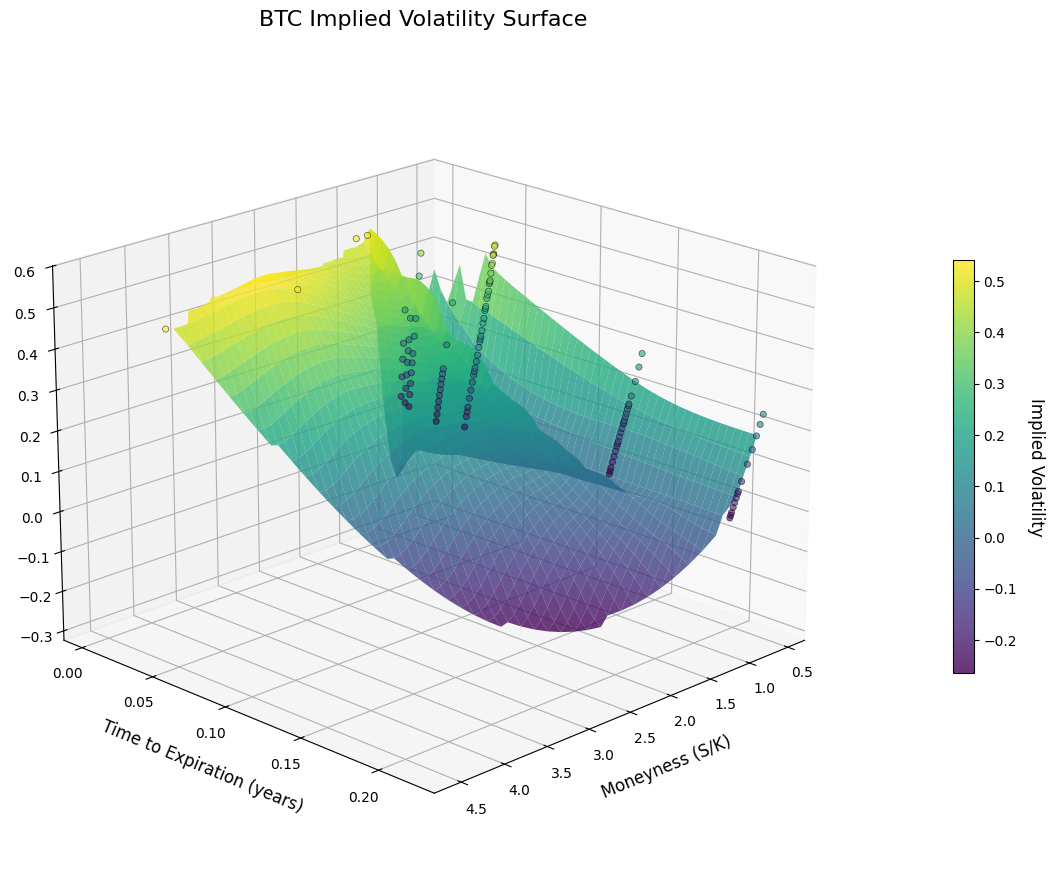

✓ BTC plot displayed (you can rotate by clicking and dragging)


In [7]:
# Plot BTC volatility surface
if len(btc_processed) > 0:
    print("Generating BTC volatility surface...")
    fig_btc = plot_vol_surface(btc_processed, "BTC", cmap='viridis')
    plt.show()
    print("✓ BTC plot displayed (you can rotate by clicking and dragging)")
else:
    print("⚠ No valid BTC data to plot")


### Plot 2: Ethereum (ETH) Volatility Surface

**Data Used:**
- All valid ETH call options from the dataset
- Same methodology as BTC analysis
- Different color scheme (Plasma) to distinguish from BTC

**What to Look For:**
- **Comparison with BTC**: How does ETH volatility compare to BTC?
- **Volatility patterns**: Are the patterns similar or different?
- **Relative levels**: Is ETH more or less volatile than BTC according to the market?
- **Market structure**: Are there differences in how ETH options are priced?

**Key Observations:**
- Crypto assets often show higher volatility than traditional assets
- ETH may have different volatility characteristics than BTC due to different use cases and market dynamics


Generating ETH volatility surface...


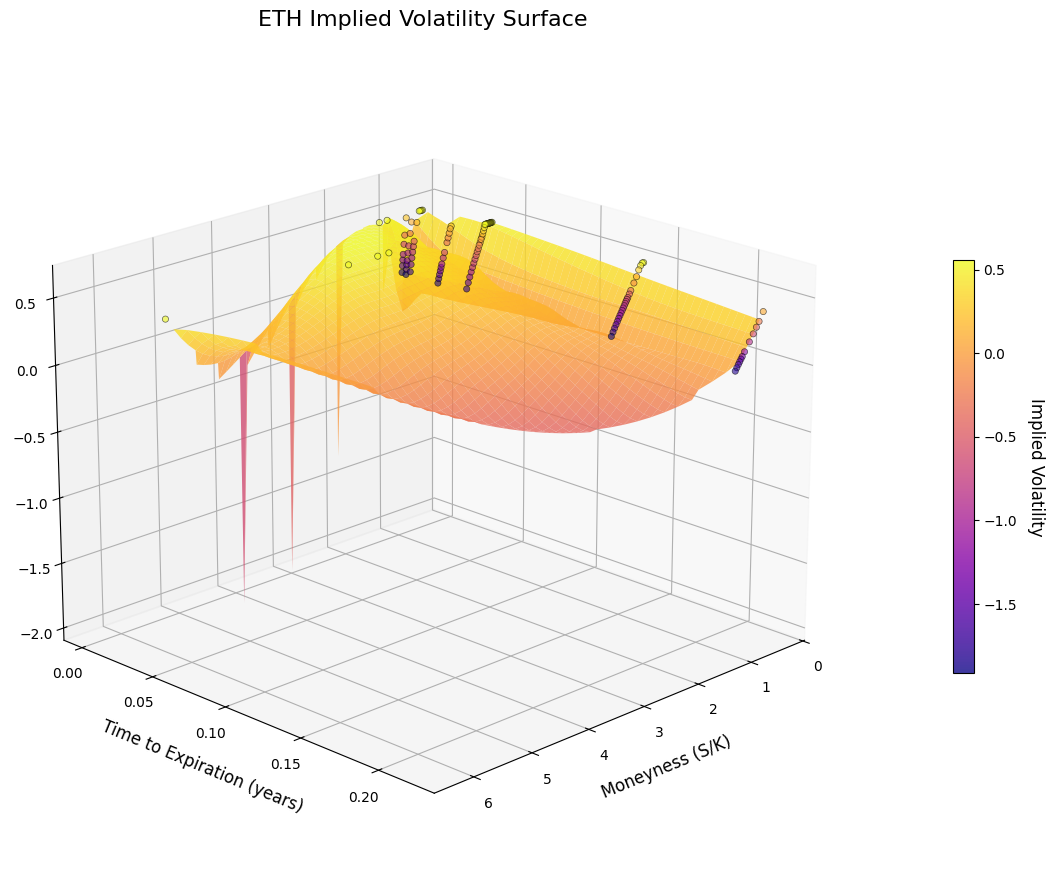

✓ ETH plot displayed (you can rotate by clicking and dragging)


In [8]:
# Plot ETH volatility surface
if len(eth_processed) > 0:
    print("Generating ETH volatility surface...")
    fig_eth = plot_vol_surface(eth_processed, "ETH", cmap='plasma')
    plt.show()
    print("✓ ETH plot displayed (you can rotate by clicking and dragging)")
else:
    print("⚠ No valid ETH data to plot")


### Plot 3: Side-by-Side Comparison (BTC vs ETH)

**Data Used:**
- Both BTC and ETH processed datasets
- Displayed as scatter plots (individual points) rather than mesh surfaces
- This allows for easier direct comparison

**What to Look For:**
- **Direct comparison**: Side-by-side view makes it easy to compare volatility levels
- **Pattern differences**: Are the shapes of the surfaces similar?
- **Density**: Which asset has more options at different moneyness/expiration combinations?
- **Volatility ranges**: Compare the IV ranges between the two assets

**Visualization Type:**
- Uses 3D scatter plots instead of mesh surfaces
- Each point is an individual option contract
- Color intensity shows IV level
- Easier to see data density and gaps in the surface


Generating side-by-side comparison...


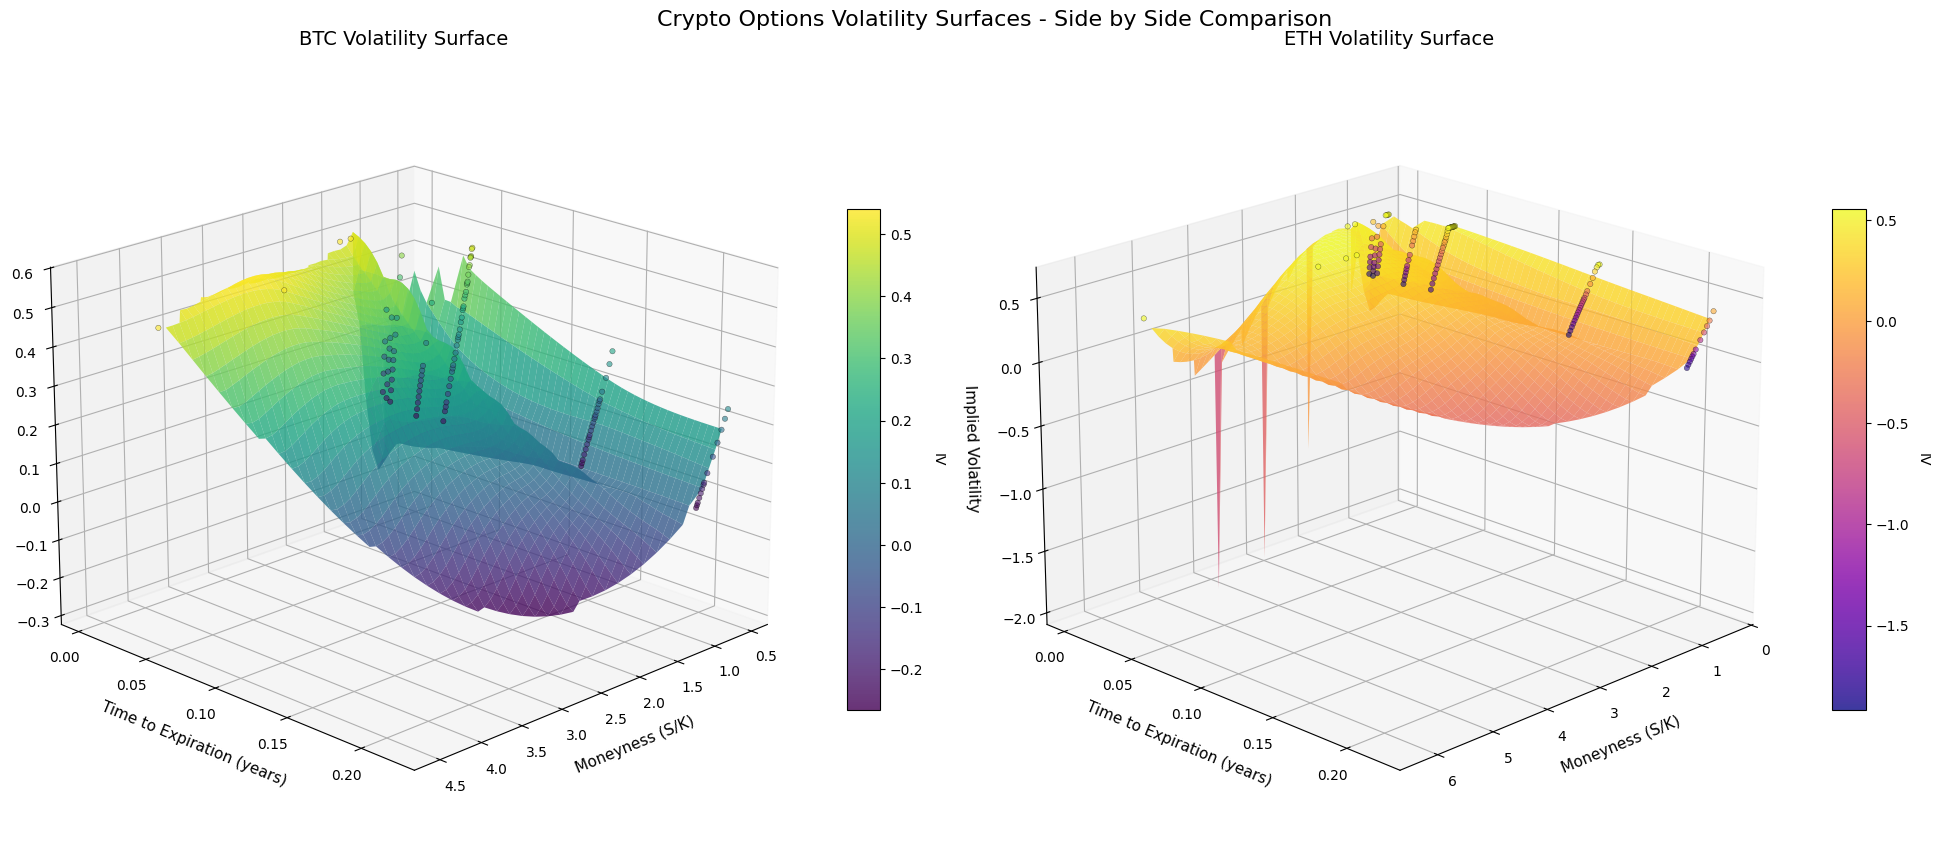

✓ Side-by-side comparison displayed
  - Left: BTC options (viridis colormap)
  - Right: ETH options (plasma colormap)
  - Each point represents one option contract
  - Rotate by clicking and dragging on each plot


In [9]:
# Create side-by-side comparison plot
if len(btc_processed) > 0 and len(eth_processed) > 0:
    print("Generating side-by-side comparison...")
    
    # Create figure with two subplots
    fig = plt.figure(figsize=(20, 9))
    
    # Helper function to create a surface plot on a given axis
    def plot_surface_on_axis(ax, df, title, cmap_name):
        """Plot volatility surface on a given axis"""
        x = df['moneyness'].values
        y = df['dte'].values
        z = df['iv'].values
        
        # Create grid for interpolation
        xi = np.linspace(x.min(), x.max(), 50)
        yi = np.linspace(y.min(), y.max(), 50)
        xi_grid, yi_grid = np.meshgrid(xi, yi)
        
        # Interpolate
        zi = griddata((x, y), z, (xi_grid, yi_grid), method='cubic')
        
        # Plot surface
        surf = ax.plot_surface(
            xi_grid, yi_grid, zi,
            cmap=cmap_name,
            alpha=0.8,
            linewidth=0.1,
            antialiased=True,
            edgecolor='none'
        )
        
        # Add scatter points
        ax.scatter(x, y, z, c=z, cmap=cmap_name, s=15, alpha=0.6, 
                   edgecolors='black', linewidth=0.3)
        
        # Labels and title
        ax.set_xlabel('Moneyness (S/K)', fontsize=11, labelpad=8)
        ax.set_ylabel('Time to Expiration (years)', fontsize=11, labelpad=8)
        ax.set_zlabel('Implied Volatility', fontsize=11, labelpad=8)
        ax.set_title(title, fontsize=14, pad=15)
        
        # Set viewing angle
        ax.view_init(elev=20, azim=45)
        
        # Add colorbar
        cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=15, pad=0.05)
        cbar.set_label('IV', rotation=270, labelpad=15, fontsize=10)
        
        return surf
    
    # Left subplot: BTC
    ax1 = fig.add_subplot(121, projection='3d')
    plot_surface_on_axis(ax1, btc_processed, 'BTC Volatility Surface', 'viridis')
    
    # Right subplot: ETH
    ax2 = fig.add_subplot(122, projection='3d')
    plot_surface_on_axis(ax2, eth_processed, 'ETH Volatility Surface', 'plasma')
    
    # Overall title
    fig.suptitle('Crypto Options Volatility Surfaces - Side by Side Comparison', 
                 fontsize=16, y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Side-by-side comparison displayed")
    print("  - Left: BTC options (viridis colormap)")
    print("  - Right: ETH options (plasma colormap)")
    print("  - Each point represents one option contract")
    print("  - Rotate by clicking and dragging on each plot")
else:
    print("⚠ Need both BTC and ETH data for comparison plot")


## Conclusion and Next Steps

### What We've Accomplished

1. ✅ Implemented the Black-Scholes pricing model
2. ✅ Built an implied volatility solver using Newton's method (available but not used in this analysis)
3. ✅ Processed real BTC and ETH options data using Deribit's provided implied volatility (mark_iv)
4. ✅ Created interactive 3D volatility surface visualizations
5. ✅ Compared volatility patterns between BTC and ETH

### Key Insights to Look For

When analyzing the volatility surfaces, consider:

1. **Volatility Smile/Skew**:
   - A "smile" indicates higher IV for both deep ITM and OTM options
   - A "skew" shows asymmetric patterns (often higher IV for OTM puts)

2. **Term Structure**:
   - Upward sloping: Longer-dated options have higher IV (uncertainty increases with time)
   - Downward sloping: Short-term volatility expectations are higher
   - Flat: Market expects constant volatility across maturities

3. **Market Implications**:
   - High IV: Market expects high price volatility (fear/uncertainty)
   - Low IV: Market expects stable prices (complacency)
   - Differences between BTC and ETH may reflect different risk perceptions

### Potential Extensions

- **Put options analysis**: Analyze put options separately or compare with calls
- **Volatility forecasting**: Use the surface to predict future volatility
- **Arbitrage detection**: Identify mispriced options relative to the surface
- **Surface fitting**: Fit parametric models (e.g., SVI, Heston) to the data
- **Real-time updates**: Connect to live data feeds for real-time analysis
- **Greeks calculation**: Calculate and visualize option Greeks (Delta, Gamma, Vega, Theta)

### Notes

- The risk-free rate (r = 5%) is an assumption - adjust based on your analysis needs
- Data quality filters may exclude some valid options - review filters if needed
- IV calculation assumes Black-Scholes model is appropriate - crypto markets may show different dynamics
